# 0 - Importando bibliotecas

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import load_boston
import random

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# auxiliares modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, RFE


warnings.filterwarnings('ignore')

plt.style.use('seaborn-pastel')

%matplotlib inline


# Funções helpers

In [173]:
def generate_random_missings(df, target, number_of_columns=5):
    for _ in range(number_of_columns):
        col = random.choice(df.columns)
        if col == target:
            pass
        else:
            frac = random.uniform(0, 0.4)
            df.loc[df.sample(frac=frac).index, col] = pd.np.nan
    return df

# 1 - Importando dados

In [174]:
data = load_boston()

In [175]:
matrix = data['data']
target = data['target']
features = data['feature_names']

In [176]:
df = pd.DataFrame(data = matrix, columns = features)
df['price'] = target

In [177]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [178]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Imputando missings

In [179]:
df = generate_random_missings(df, target = 'price', number_of_columns=5)

# 2 - Análise Exploratória

## 2.1 Descrição estatística das variáveis

In [180]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
count,506.000000,399.000000,506.000000,506.000000,506.000000,500.000000,506.000000,506.000000,409.000000,506.000000,506.000000,502.000000,506.000000,506.000000
mean,3.613524,10.926065,11.136779,0.069170,0.554695,6.288484,68.574901,3.795043,9.400978,408.237154,18.455534,356.985538,12.653063,22.532806
std,8.601545,23.319852,6.860353,0.253994,0.115878,0.702000,28.148861,2.105710,8.645842,168.537116,2.164946,90.960811,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.886500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.209000,77.500000,3.207450,5.000000,330.000000,19.050000,391.475000,11.360000,21.200000
75%,3.677083,0.000000,18.100000,0.000000,0.624000,6.626000,94.075000,5.188425,24.000000,666.000000,20.200000,396.237500,16.955000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## 2.2 Correlações

<AxesSubplot:>

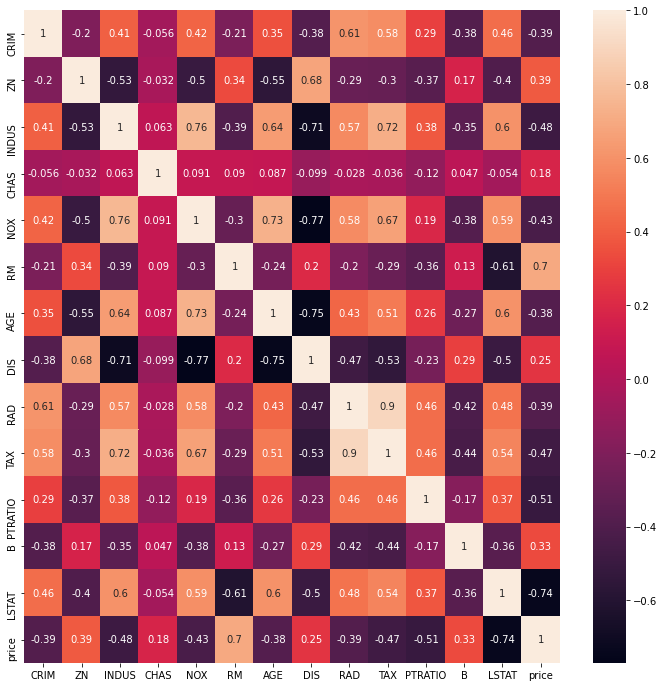

In [184]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(data = df.corr(),annot = True)

- correlação com price:
    - LSTAT - quanto mais pessoas de baixa renda, mais barato a casa
    - INDUS - quanto mais industrias, mais barato a casa
    - NOX - quanto mais poluição, mais barato a casa
    - RM - quanto mais quartos, mais cara a casa
    - ...
    
- multicolinearidade:
    - TAX-RAD: o imposto parece aumentar quando a casa é localizada próxima a rodovias
    - DIX-NOX: quanto mais distante dos centros, menor a poluição
    - AGE-NOX: quanto mais antiga, mais poluída (correlação espúria (quando não há causalidade))
    - ...

In [195]:
df.corr()['price'].sort_values()

LSTAT     -0.737663
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.388305
RAD       -0.386935
AGE       -0.376955
CHAS       0.175260
DIS        0.249929
B          0.331733
ZN         0.386681
RM         0.699295
price      1.000000
Name: price, dtype: float64

In [198]:
correlations = ['LSTAT', 'PTRATIO', 'INDUS', 'RM', 'ZN', 'B', 'price']

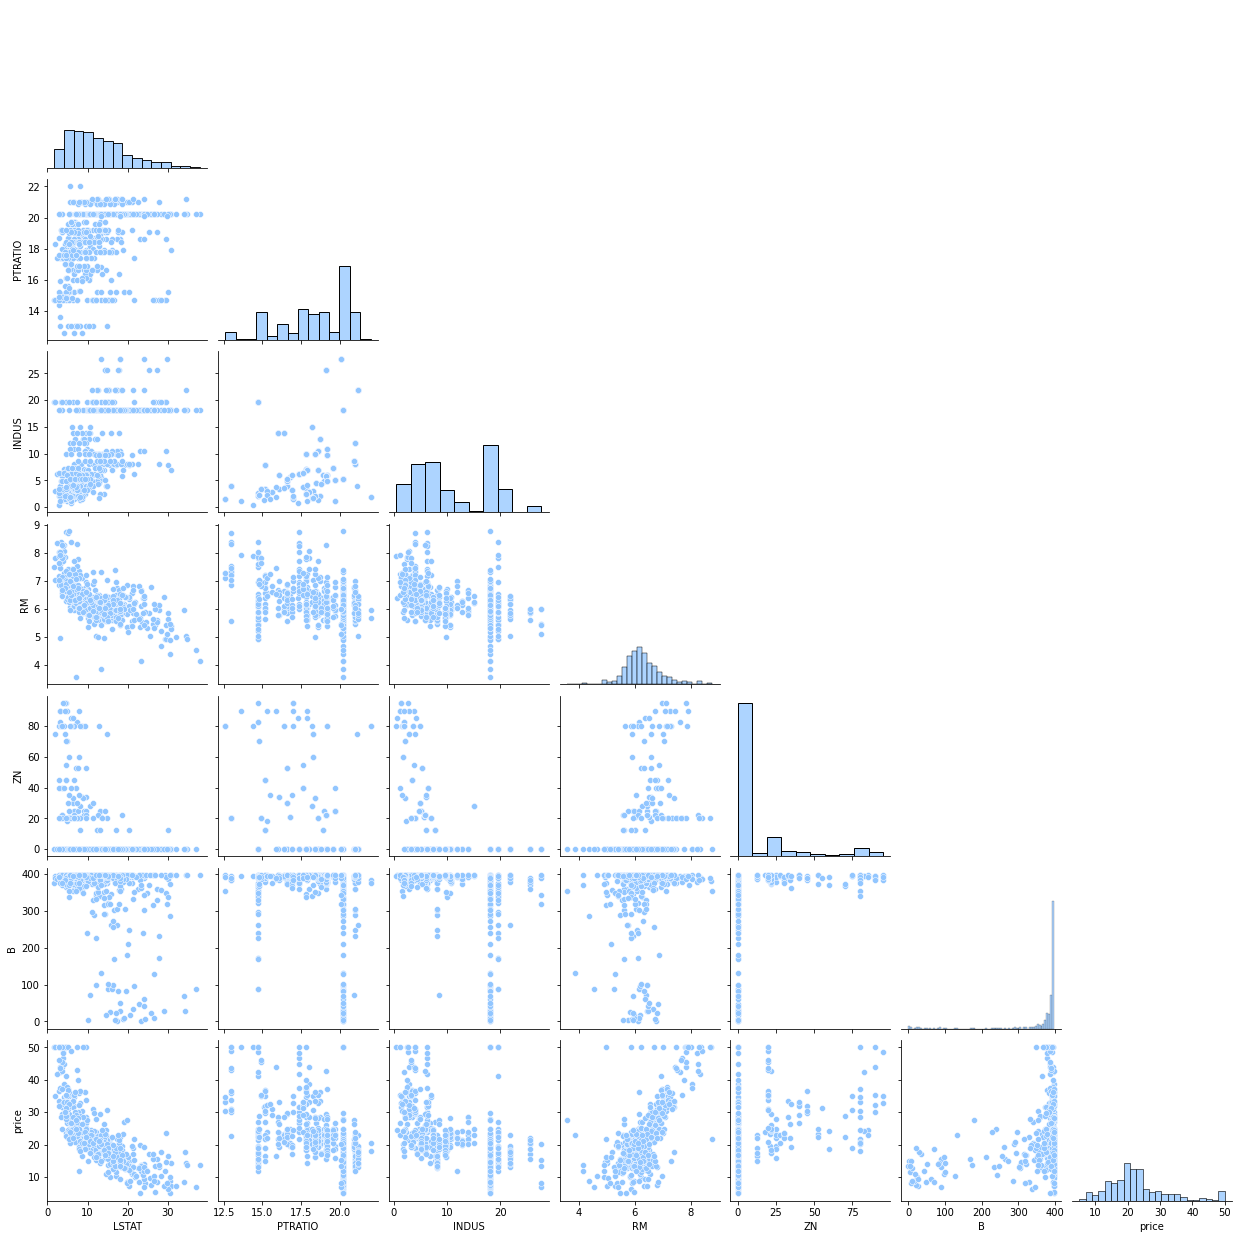

In [204]:
sns.pairplot(df[correlations], corner=True);

## 2.3 Análise Univariada

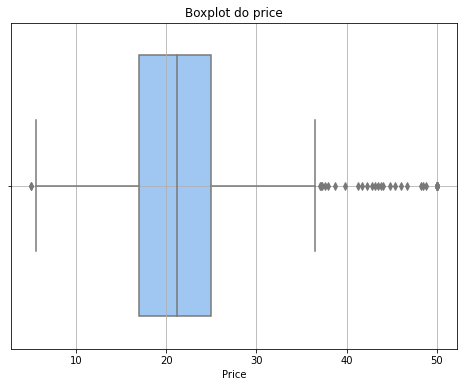

In [205]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(df['price'])
plt.grid()
plt.xlabel('Price')
#plt.ylabel('')
plt.title('Boxplot do price');

# 3 Divisão de treino/teste

In [211]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('price', axis=1), 
    df['price'], 
    test_size = 0.2, 
    random_state = 0
)

# 4 Missings

In [216]:
X_train.isnull().sum()

CRIM        0
ZN         84
INDUS       0
CHAS        0
NOX         0
RM          4
AGE         0
DIS         0
RAD        78
TAX         0
PTRATIO     0
B           3
LSTAT       0
dtype: int64

In [217]:
X_test.isnull().sum()

CRIM        0
ZN         23
INDUS       0
CHAS        0
NOX         0
RM          2
AGE         0
DIS         0
RAD        19
TAX         0
PTRATIO     0
B           1
LSTAT       0
dtype: int64

### Imputação de missings por Knn

In [218]:
# criando instância da classe KNNImputer
imputer = KNNImputer(n_neighbors=5)

# fitando e transformado para o treino
train_imputed = imputer.fit_transform(X_train)
X_train = pd.DataFrame(data=train_imputed, columns=X_train.columns)

# aplicando a transformação para o teste (evitando vazamento de dados)
test_imputed = imputer.transform(X_test)
X_test = pd.DataFrame(data=test_imputed, columns=X_test.columns)

## 5 Scalling

$ x_{norm} = \frac{x - x_{mean}}{x_{std}}  $

In [221]:
# criando instância da classe StandardScaler
sc = StandardScaler()

# fitando e transformando para treino
X_train = sc.fit_transform(X_train)

# apenas transformando para teste (evitando vazamento de dados)
X_test = sc.transform(X_test)

In [225]:
df.drop('price', axis=1).columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [226]:
X_train = pd.DataFrame(X_train, columns = df.drop('price', axis=1).columns)
X_test = pd.DataFrame(X_test, columns = df.drop('price', axis=1).columns)

In [245]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 6 Modelagem

## 6.1 Modelo Linear

In [258]:
def cross_validation(model, kf, X_train, y_train):
    list_mse_train = []
    list_mse_val = []
    list_r2_train = []
    list_r2_val = []

    for indices_train, indices_val in kf.split(X_train):
        # iterando sobre os índices de trieno e validação
        X_train_, y_train_ = X_train.loc[indices_train, :], y_train.loc[indices_train]
        X_val_, y_val_ = X_train.loc[indices_val, :], y_train.loc[indices_val]

        # treinando meu modelo no conjunto de treino
        model.fit(X_train_, y_train_)

        # predizendo resultados em treino e validação
        y_pred_train = model.predict(X_train_)
        y_pred_val = model.predict(X_val_)

        # calculando as métricas
        mse_train = mean_squared_error(y_train_, y_pred_train)
        mse_val = mean_squared_error(y_val_, y_pred_val)
        r2_train = r2_score(y_train_, y_pred_train)
        r2_val = r2_score(y_val_, y_pred_val)

        # armazenando resultados
        list_mse_train.append(mse_train)
        list_mse_val.append(mse_val)
        list_r2_train.append(r2_train)
        list_r2_val.append(r2_val)
        
    print('MSE no training: {} +- {}'.format(np.mean(list_mse_train), np.std(list_mse_train)))
    print('MSE no validation: {} +- {}'.format(np.mean(list_mse_val), np.std(list_mse_val)))
    print('r2 no training: {} +- {}'.format(np.mean(list_r2_train), np.std(list_r2_train)))
    print('r2 no validation: {} +- {}'.format(np.mean(list_r2_val), np.std(list_r2_val)))

In [357]:
# criando modelo de regressão linear
lr = LinearRegression()

# validação cruzada
kf = KFold(n_splits=5)

cross_validation(lr, kf, X_train, y_train)

MSE no training: 18.46219450483712 +- 1.502680674870813
MSE no validation: 20.53138084308473 +- 6.046194052291919
r2 no training: 0.7832100298762841 +- 0.013411603178966482
r2 no validation: 0.7579677709842858 +- 0.04649850104957092


In [358]:
print("R2 no Teste: {}".format(r2_score(y_test, lr.predict(X_test))))
print("MSE no Teste: {}".format(mean_squared_error(y_test, lr.predict(X_test))))

R2 no Teste: 0.5853390087369272
MSE no Teste: 33.76519725841187


## 6.2 Modelo de distância

In [259]:
knn = KNeighborsRegressor(n_neighbors=5)

cross_validation(knn, kf, X_train, y_train)

MSE no training: 12.992154700913506 +- 1.445785627388897
MSE no validation: 20.449567358024694 +- 6.1081190062367465
r2 no training: 0.8473147103039524 +- 0.015896716860310505
r2 no validation: 0.760670500294678 +- 0.051062754268757594


In [359]:
print("R2 no Teste: {}".format(r2_score(y_test, knn.predict(X_test))))
print("MSE no Teste: {}".format(mean_squared_error(y_test, knn.predict(X_test))))

R2 no Teste: 0.5113780636470004
MSE no Teste: 39.78772156862745


O modelo de KNN está mais overfitado que o modelo linear, pois o delta entre métricas de treino e validação ficou maior.

## 6.3 Modelo de árvore

In [268]:
dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=0)

cross_validation(dt, kf, X_train, y_train)

MSE no training: 14.839274827234732 +- 0.9170108747329435
MSE no validation: 22.546230536953203 +- 7.24519991898321
r2 no training: 0.825630877915484 +- 0.007936182015391787
r2 no validation: 0.7231584455330019 +- 0.1131686056399482


In [360]:
print("R2 no Teste: {}".format(r2_score(y_test, dt.predict(X_test))))
print("MSE no Teste: {}".format(mean_squared_error(y_test, dt.predict(X_test))))

R2 no Teste: 0.5967432480141794
MSE no Teste: 32.83656785537681


## 6.4 Modelo ensemble

In [363]:
rf = RandomForestRegressor(n_estimators=500, max_depth=3, min_samples_leaf=5, random_state=0)

cross_validation(rf, kf, X_train, y_train)

MSE no training: 10.488238820089245 +- 0.7475226980492506
MSE no validation: 16.10568182919119 +- 5.581028043099477
r2 no training: 0.8766280634754627 +- 0.008862387258246887
r2 no validation: 0.8095020180335606 +- 0.052936544039161856


In [364]:
print("R2 no Teste: {}".format(r2_score(y_test, rf.predict(X_test))))
print("MSE no Teste: {}".format(mean_squared_error(y_test, rf.predict(X_test))))

R2 no Teste: 0.6549293209255013
MSE no Teste: 28.098566763066017


O Random Forest parece ser o mais promissor. Suas métrica são superiores aos outros modelos, porém ainda overfita bastante. Vamos tentar parametrizar melhor.

### 6.4.1 Feature Importance

In [330]:
pd.DataFrame(
    data = rf.feature_importances_, 
    index = X_train.columns,
    columns=['Importância']
).reset_index().sort_values(by='Importância', ascending=False)

,index,Importância
12,LSTAT,0.491775
5,RM,0.414581
0,CRIM,0.045244
7,DIS,0.015080
4,NOX,0.012614
10,PTRATIO,0.010841
8,RAD,0.002699
6,AGE,0.001903
2,INDUS,0.001789
11,B,0.001732


# 7 Hyperparametrização

## 7.1 Grid Search

In [296]:
# Definindo grid para busca
params_grid = {
    'n_estimators': [100, 300, 600, 1000],
    'max_features': ['auto'],
    'max_depth': [2,3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# criando nosso modelo de grid search
gridsearch_model = GridSearchCV(
    estimator = rf, 
    param_grid = params_grid,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    cv = 5,
    verbose = 2
)

In [297]:
%time gridsearch_model.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 3.97 s, sys: 174 ms, total: 4.14 s
Wall time: 2min 44s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=2, min_samples_leaf=5,
                                             n_estimators=500, random_state=0),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 3],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 600, 1000]},
             scoring='neg_mean_absolute_error', verbose=2)

In [298]:
print('Melhores parâmetros: ')
print(gridsearch_model.best_params_)

Melhores parâmetros: 
{'bootstrap': True, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}


In [299]:
best_grid_rf = gridsearch_model.best_estimator_

## 7.1 Random Search

In [306]:
# Definindo grid para busca
params_grid = {
    'n_estimators': [100, 300, 600, 1000],
    'max_features': ['auto'],
    'max_depth': [2,3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# criando nosso modelo de grid search
randomsearch_model = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = params_grid,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    cv = 5,
    verbose = 2
)

In [307]:
%time randomsearch_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 1.2 s, sys: 23.7 ms, total: 1.23 s
Wall time: 18.9 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=2,
                                                   min_samples_leaf=5,
                                                   n_estimators=500,
                                                   random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [2, 3],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 600, 1000]},
                   scoring='neg_mean_absolute_error', verbose=2)

In [308]:
print('Melhores parâmetros: ')
print(randomsearch_model.best_params_)

Melhores parâmetros: 
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 2, 'bootstrap': True}


In [310]:
best_random_rf = randomsearch_model.best_estimator_

# 8 Resultados

## 8.1 grid search

In [300]:
y_pred_test = best_grid_rf.predict(X_test)

print("R2 no conjunto de testes: {}".format(r2_score(y_test, y_pred_test)))
print("Mean squared error no conjunto de testes: {}".format(mean_squared_error(y_test, y_pred_test)))

R2 no conjunto de testes: 0.6728409769855679
Mean squared error no conjunto de testes: 26.64004856908118


In [301]:
best_grid_rf.score(X_train, y_train)

0.873324460068411

In [302]:
cross_validation(best_grid_rf, kf, X_train, y_train)

MSE no training: 10.185740710680294 +- 0.6925855006525845
MSE no validation: 15.997003231416816 +- 5.512884146688594
r2 no training: 0.8801927267410411 +- 0.008126353553428103
r2 no validation: 0.8109981818127038 +- 0.05136109025353893


## 8.2 random search

In [311]:
y_pred_test = best_random_rf.predict(X_test)

print("R2 no conjunto de testes: {}".format(r2_score(y_test, y_pred_test)))
print("Mean squared error no conjunto de testes: {}".format(mean_squared_error(y_test, y_pred_test)))

R2 no conjunto de testes: 0.650721570810732
Mean squared error no conjunto de testes: 28.44119728687421


In [312]:
best_random_rf.score(X_train, y_train)

0.8008785211715315

In [313]:
cross_validation(best_random_rf, kf, X_train, y_train)

MSE no training: 16.13983613467185 +- 0.9635646232444236
MSE no validation: 20.62608637664288 +- 6.543980618706637
r2 no training: 0.8100926815976497 +- 0.01233792322381996
r2 no validation: 0.755972375517417 +- 0.055576441750096135


# 9 Seleção de variáveis

## 9.1 Recursive feature elimination

In [342]:
selector = RFE(rf, n_features_to_select=6, step=1)
selector = selector.fit(X_train, y_train)

In [344]:
mascara_best_features = selector.support_

X_train_rfe = X_train.loc[:, mascara_best_features].copy()
X_test_rfe = X_test.loc[:, mascara_best_features].copy()

In [345]:
cross_validation(rf, kf, X_train_rfe, y_train)

MSE no training: 10.722917776246305 +- 0.7640973185957147
MSE no validation: 16.064705008423793 +- 5.707097209906269
r2 no training: 0.8738804658392384 +- 0.008901846564584263
r2 no validation: 0.8098085010660403 +- 0.05508009443415022


## 9.2 Boruta

In [351]:
from boruta import BorutaPy

# inicializando boruta
boruta = BorutaPy(
    estimator = rf, 
    n_estimators = 'auto',
    max_iter = 100,
    random_state = 0
)

# Selecionando as variáveis
boruta.fit(np.array(X_train), np.array(y_train))

### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT']
features in the blue area: ['INDUS']


In [353]:
X_train_boruta = X_train[green_area].copy()
X_test_boruta = X_test[green_area].copy()

In [355]:
cross_validation(rf, kf, X_train_boruta, y_train)

MSE no training: 10.513675989077651 +- 0.7999516086424359
MSE no validation: 16.052117355672355 +- 5.580188685689784
r2 no training: 0.8763546836841141 +- 0.009158279257916622
r2 no validation: 0.8097451626036557 +- 0.054832395556249566


# Conclusões

- testamos alguns modelos:
    - linear regression
    - knn
    - decision tree
    - random forest
- avaliamos em validação cruzada
- testamos otimização de hiperparâmetros
    - grid search
    - random search
- testamos seleção de variáveis
    - RFE
    - Boruta
    
- Concluimos que o melhor modelo encontrado ainda assim overfita
- Dentro os modelos testados, o que menos overfitou foi o RF
- Portanto, na escolha do melhor modelo, escolheria o RF